In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [5]:
train_dataset[0][0].max()

tensor(1.)

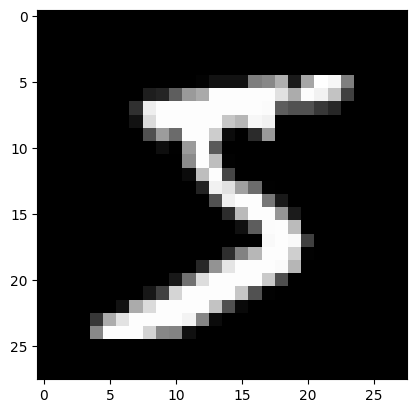

In [6]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0), cmap="gray")

In [7]:
### https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1

class DDPM(nn.Module):
    def __init__(self,
                 model,
                 n_steps=200,
                 min_beta=10 ** -4,
                 max_beta=0.02,
                 device=None,
                 image_chw=(1, 28, 28),) -> None:
        super(DDPM, self).__init__()
        
        self.model = model
        self.n_steps = n_steps
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.device = device
        self.image_chw = image_chw
        
        self.beta_list = (
            torch
            .linspace(self.min_beta,
                      self.max_beta,
                      self.n_steps,)
            .to(self.device)
        )
        
        self.alpha_list = 1 - self.beta_list
        self.alpha_bar_list = (
            torch
            .cumprod(self.alpha_list, dim=0)
            .to(self.device)
        )
        
    def forward_proc(self, x0, t, eta):
        n, c, h, w = x0.shape
        alpha_bar_t = self.alpha_bar_list[t]
        
        noisy = (
            alpha_bar_t.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - alpha_bar_t).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy
    
    def backward_proc(self, x, condition_mask, t, n):
        x_prev = self.model(x, condition_mask, t, n)
        return x_prev
    
    def get_condition_mask(self, labels, drop_prob=0.3, num_classes=10):

        onehot_labels = (
            torch
            .nn
            .functional
            .one_hot(labels, num_classes=num_classes)
            .type(torch.float)
            .to(device)
        )
        condition_mask = (
            torch
            .bernoulli(torch.zeros_like(labels)+drop_prob)
            .to(device)
        )

        condition_mask = condition_mask[:, None]
        condition_mask = condition_mask.repeat(1, num_classes)
        condition_mask = (-1 * (1 - condition_mask))  # -1 or 0
        condition_mask = onehot_labels * condition_mask
        return condition_mask

In [8]:
class DiffusionModel(nn.Module):
    def __init__(self, n_steps=1000, emb_dim=100, n_classes=10):
        super(DiffusionModel, self).__init__()
        
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, emb_dim)
        self.time_embed.weight.data = self.sinusoidal_embedding(n_steps, emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.ln1 = nn.LayerNorm((1, 28, 28))
        self.conv1 = nn.Conv2d(1, 10, 4, 2, 1)
        self.ln2 = nn.LayerNorm((10, 14, 14))
        self.conv2 = nn.Conv2d(10, 20, 4, 2, 2)
        self.ln3 = nn.LayerNorm((20, 8, 8))
        self.conv3 = nn.Conv2d(20, 40, 4, 2, 1)
        # self.ln4 = nn.LayerNorm((40, 4, 4))
        # self.conv4 = nn.Conv2d(40, 64, 4, 2, 1)
        
        # self.te4 = self.make_embedding(emb_dim, 6)
        # self.ce4 = self.make_embedding(n_classes, 64)
        # self.lnT4 = nn.LayerNorm((64, 2, 2))
        # self.convT4 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.te3 = self.make_embedding(emb_dim, 40)
        self.ce3 = self.make_embedding(n_classes, 40)
        self.lnT3 = nn.LayerNorm((40, 4, 4))
        self.convT3 = nn.ConvTranspose2d(40, 20, 4, 2, 1)
        self.te2 = self.make_embedding(emb_dim, 2*20)
        self.ce2 = self.make_embedding(n_classes, 2*20)
        self.lnT2 = nn.LayerNorm((2*20, 8, 8))
        self.convT2 = nn.ConvTranspose2d(2*20, 10, 4, 2, 2)
        self.te1 = self.make_embedding(emb_dim, 2*10)
        self.ce1 = self.make_embedding(n_classes, 2*10)
        self.lnT1 = nn.LayerNorm((2*10, 14, 14))
        self.convT1 = nn.ConvTranspose2d(2*10, 1, 4, 2, 1)
        
        # self.conv_out = nn.Conv2d(4, 1, 3, 1, 1)
        
        self.silu = nn.SiLU()
        
    def forward(self, x, condition_mask, t, n):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        c = condition_mask
        cat = lambda x: torch.cat(x, dim=1)
        unsqz = lambda x: x.unsqueeze(-1).unsqueeze(-1)
        
        x_1 = self.silu(self.conv1(self.ln1(x)))
        x_2 = self.silu(self.conv2(self.ln2(x_1)))
        x_3 = self.silu(self.conv3(self.ln3(x_2)))
        # x_4 = self.silu(self.conv4(self.ln4(x_3)))
        
        # x_T4 = self.silu(self.convT4(self.lnT4(unsqz(self.ce4(c)) * x_4 + unsqz(self.te4(t)))))
        x_T3 = self.silu(self.convT3(self.lnT3(unsqz(self.ce3(c)) * cat([x_T4, x_3]) + unsqz(self.te3(t)))))
        x_T2 = self.silu(self.convT2(self.lnT2(unsqz(self.ce2(c)) * cat([x_T3, x_2]) + unsqz(self.te2(t)))))
        # x_T1 = self.silu(self.convT1(self.lnT1(unsqz(self.ce1(c)) * cat([x_T2, x_1]) + unsqz(self.te1(t)))))
        out = self.convT1(self.lnT1(unsqz(self.ce1(c)) * cat([x_T2, x_1]) + unsqz(self.te1(t))))
        
        # out = self.conv_out(x_T1)
        return out

    def sinusoidal_embedding(self, n, d):
        # Returns the standard positional embedding
        embedding = torch.zeros(n, d)
        wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
        wk = wk.reshape((1, d))
        t = torch.arange(n).reshape((n, 1))
        embedding[:,::2] = torch.sin(t * wk[:,::2])
        embedding[:,1::2] = torch.cos(t * wk[:,::2])

        return embedding
    
    def make_embedding(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [9]:
n_steps, min_beta, max_beta = 1000, 10**-4, 0.0005 # Originally used by the authors
model = DiffusionModel(n_steps).to(device)
ddpm = DDPM(
    model=model,
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

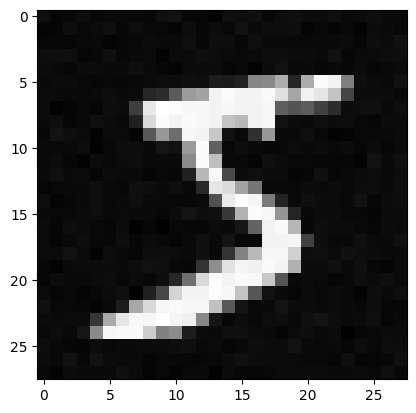

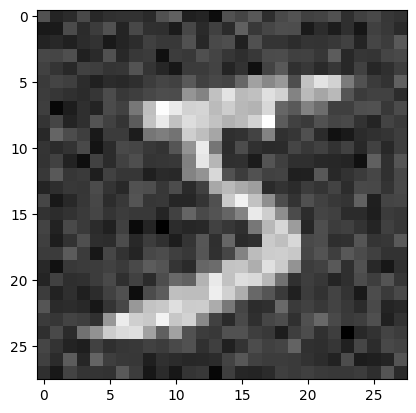

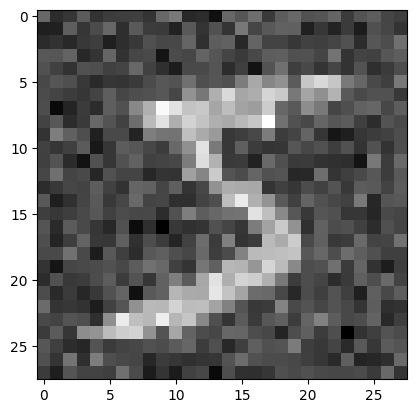

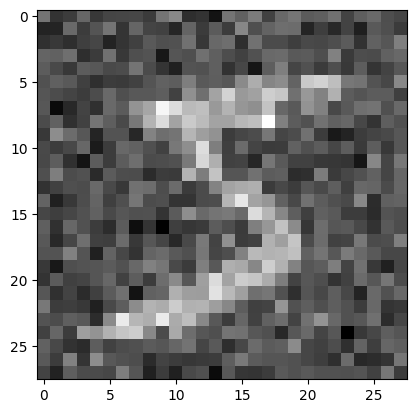

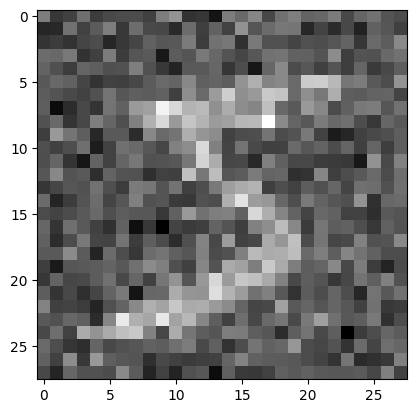

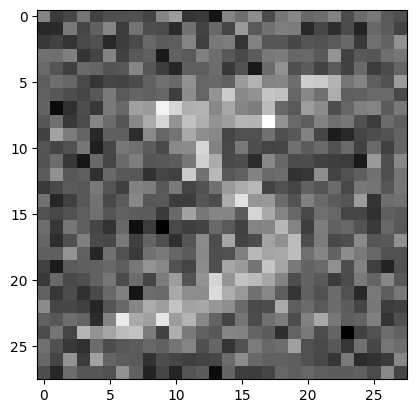

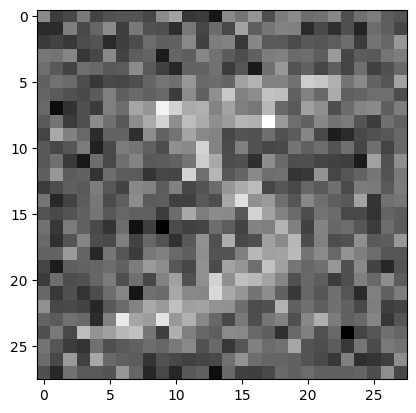

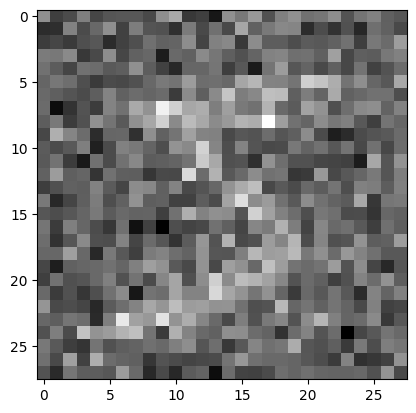

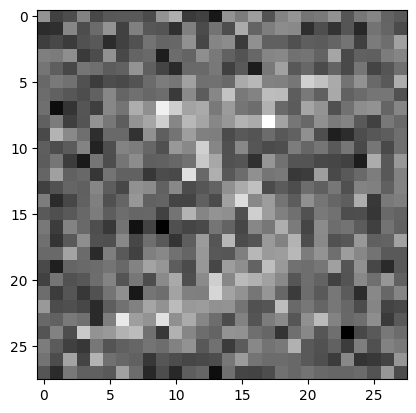

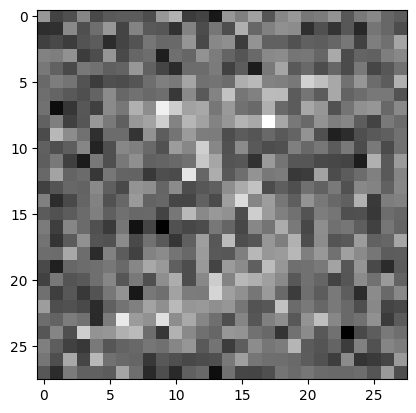

In [10]:
images = train_dataset[0][0].reshape(-1, 1, 28, 28).to(device)
noise = torch.randn_like(images).to(device)
for i in [1,111,222,333,444,555,666,777,888,999]:
    noisy = ddpm.forward_proc(images, i, noise)
    plt.imshow(noisy[0].permute(1, 2, 0).cpu(), cmap="gray")
    plt.show()

In [11]:
samples = torch.randn(10, 1, 28, 28).to(device)


num_epochs = 100
            
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        batch_size = images.shape[0]
        t = torch.randint(0, n_steps-1, (batch_size,), device=device, dtype=torch.long)
        
        noise = torch.randn_like(images).to(device)
        noisy = ddpm.forward_proc(images, t, noise)
        condition_mask = ddpm.get_condition_mask(labels, drop_prob=0.3, num_classes=10)
        outputs = ddpm.backward_proc(noisy, condition_mask, t, batch_size)
        
        
        loss = criterion(noise, outputs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")
    
    with torch.no_grad():
        labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        x_t = copy.deepcopy(samples)
        for t in range(n_steps-1, 0, -1):
            t = torch.tensor(t).to(device)
            condition_mask = ddpm.get_condition_mask(labels, drop_prob=0.0, num_classes=10)
            pred = ddpm.backward_proc(x_t, condition_mask, t, 10)
            noise = torch.randn_like(samples).to(device)

            beta_t = ddpm.beta_list[t]
            alpha_t = ddpm.alpha_list[t]
            alpha_bar_t = ddpm.alpha_bar_list[t]
            alpha_bar_t_prev = ddpm.alpha_bar_list[t-1]
            
            x_t = x_t - (1-alpha_t) / (1e-6 + (1-alpha_bar_t).sqrt()) * pred
            x_t = (1 / (1e-6 + alpha_t.sqrt())) * x_t
            
            std = torch.sqrt(beta_t*(1-alpha_bar_t_prev)/(1-alpha_bar_t))
            
            x_t = x_t + std * noise
            
        
        fig, axs = plt.subplots(1, 10)
        normalized = x_t.clone()
        for i in range(len(normalized)):
            normalized[i] -= torch.min(normalized[i])
            normalized[i] *= 255 / torch.max(normalized[i])
            axs[i].imshow((normalized[i]).permute(1, 2, 0).cpu().detach().numpy(),cmap="gray")
            axs[i].set_axis_off()
            axs[i].set_title(i)
        plt.show()
    
        
    
    


AttributeError: 'DiffusionModel' object has no attribute 'conv4'